<a href="https://colab.research.google.com/github/elsaimo/4106_Final_project/blob/main/MohamedFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 10/100, Training Loss: 2.1354, Validation Loss: 2.0612
Train RMSE: 1.4613, Val RMSE: 1.4357
Epoch 20/100, Training Loss: 0.6008, Validation Loss: 0.6370
Train RMSE: 0.7751, Val RMSE: 0.7981
Epoch 30/100, Training Loss: 0.3829, Validation Loss: 0.4788
Train RMSE: 0.6188, Val RMSE: 0.6920
Epoch 40/100, Training Loss: 0.3244, Validation Loss: 0.3999
Train RMSE: 0.5696, Val RMSE: 0.6324
Epoch 50/100, Training Loss: 0.2266, Validation Loss: 0.3359
Train RMSE: 0.4760, Val RMSE: 0.5796
Epoch 60/100, Training Loss: 0.1902, Validation Loss: 0.2970
Train RMSE: 0.4361, Val RMSE: 0.5450
Epoch 70/100, Training Loss: 0.1813, Validation Loss: 0.2468
Train RMSE: 0.4258, Val RMSE: 0.4968
Epoch 80/100, Training Loss: 0.1358, Validation Loss: 0.1841
Train RMSE: 0.3685, Val RMSE: 0.4290
Epoch 90/100, Training Loss: 0.1541, Validation Loss: 0.1970
Train RMSE: 0.3926, Val RMSE: 0.4439
Epoch 100/100, Training Loss: 0.1342, Validation Loss: 0.1729
Train RMSE: 0.3664, Val RMSE: 0.4158
Epoch 10/100, Train

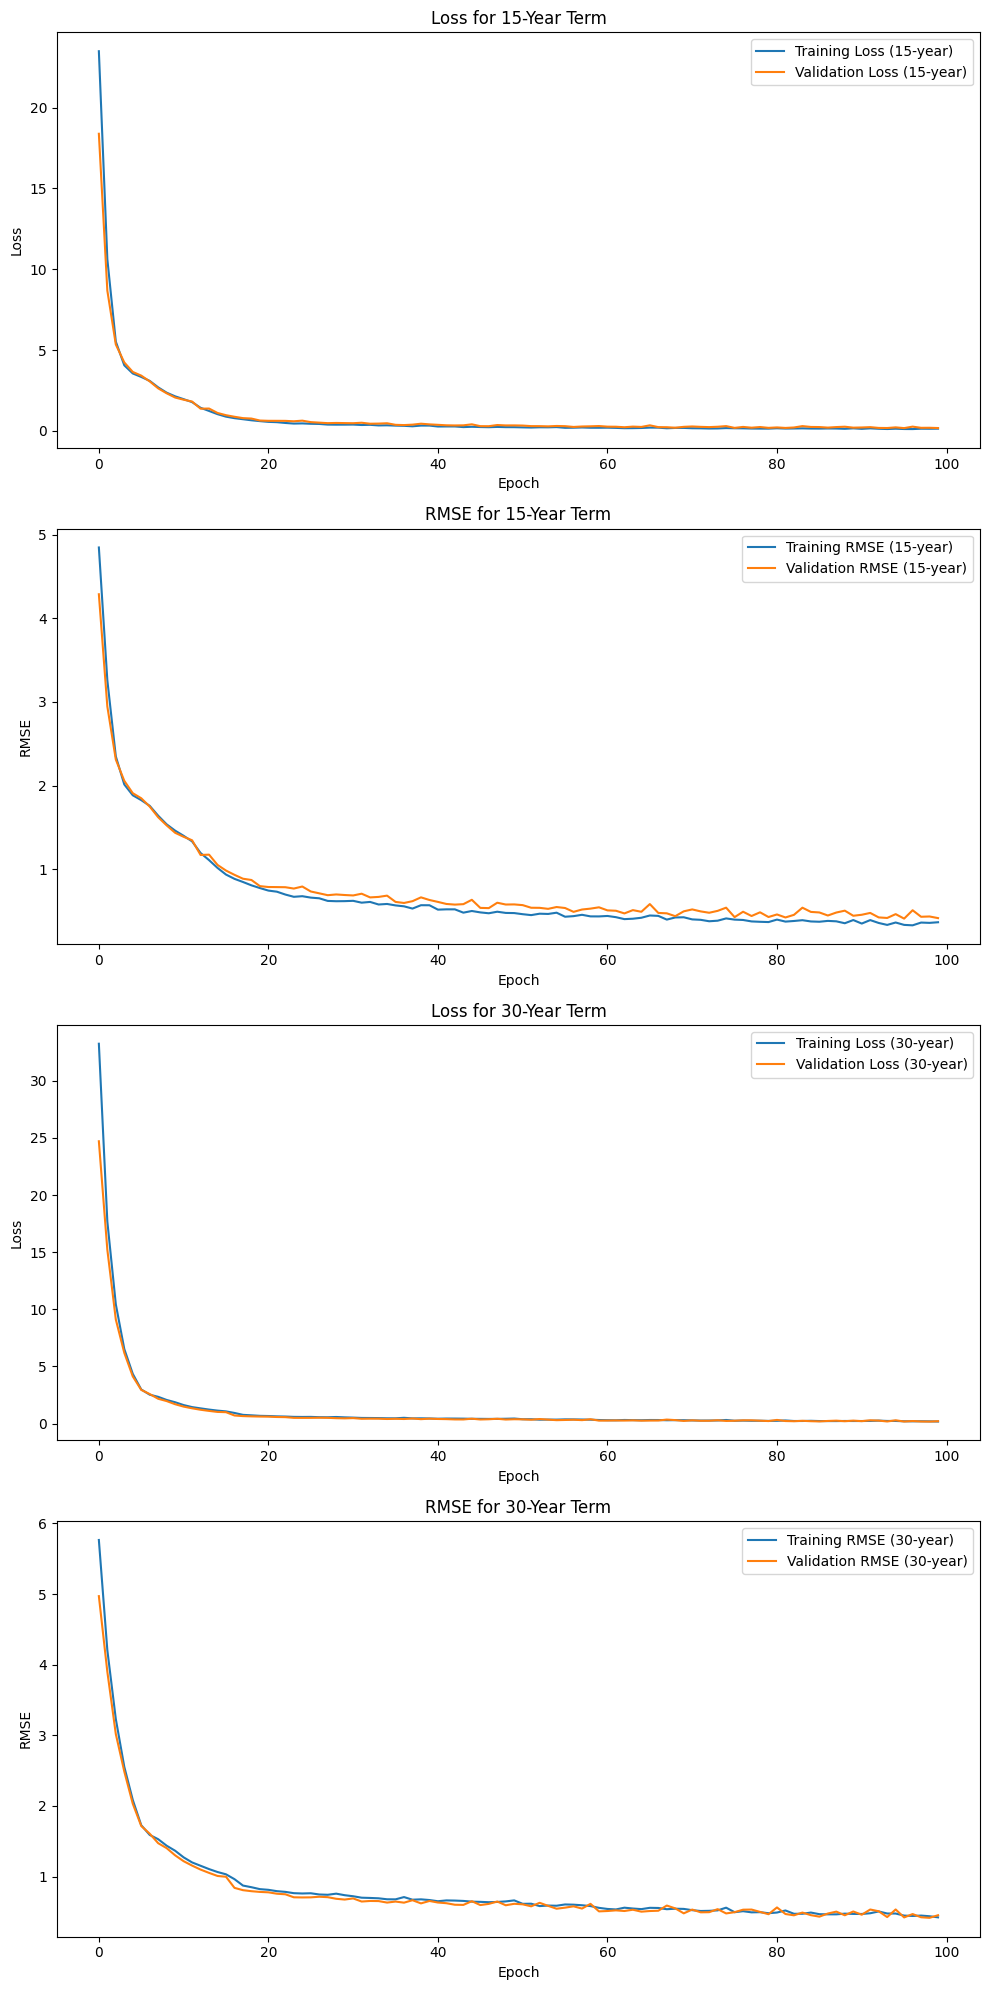

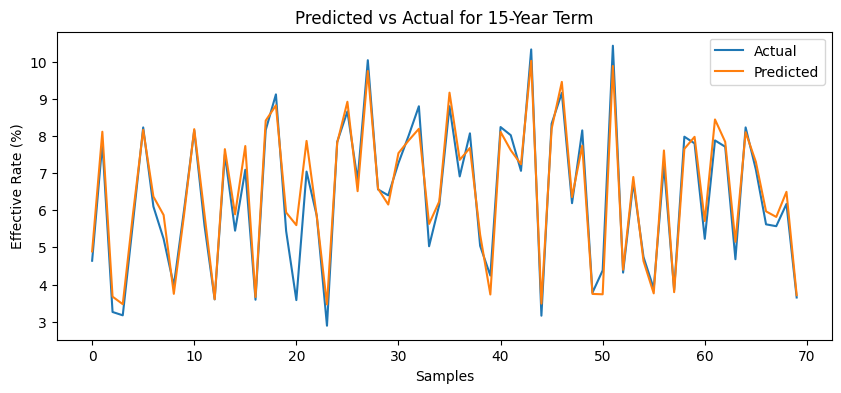

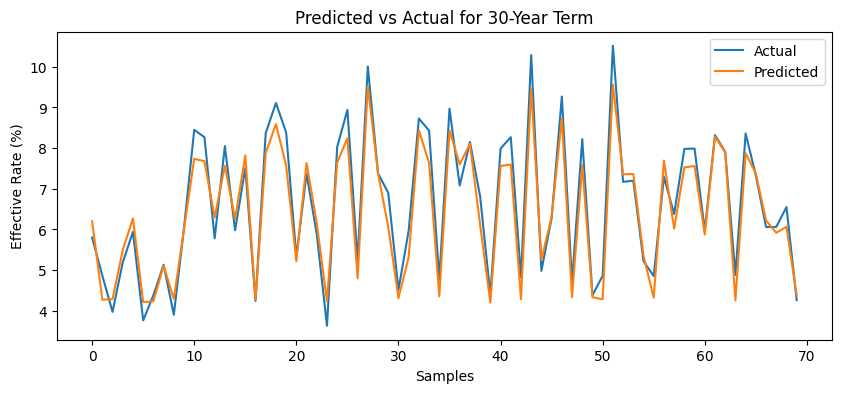

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define GRU model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = '/content/sample_data/Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)


    #input_size, hidden_size, num_layers, output_size
    model_15 = SimpleRNN(7, 50, 1, 1)
    model_30 = SimpleRNN(7, 50, 1, 1)

    batch_szie = 8
    train_loader_15, val_loader_15 = prepare_data(X_15, y_15, batch_szie)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30, batch_szie)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')


